<a href="https://colab.research.google.com/github/AlexanderAlmeida/pos_graduacao/blob/master/MVP_Analytcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Definição do Problema


# MVP - Crédito Consignado

    O objetivo principal é analisar os dados para ser mais assertivo na venda do crédito consignado. A regra principal consiste em ser menor que 85 anos de idade, com margem de saldo superior à 35% dos parcelamentos vigentes. Estará sendo utilizado um dataset real e a idéia é analisar a idade, volume de UF e Margem Saldo.

**Dataset**

O dataset possui 7915 instâncias e 7 atributos, com um mix de tipos de dados categóricos e numéricos. Abaixo a descrição das colunas:

Colunas:

    Sexo: sexo do cidadão
    Idade: idade do cidadão
    UF: unidade federativa
    Situação Funcional: Aposentado / Ativo e etc...
    Pmt_Valor: Valor total dos parcelamentos vigentes
    Margem_Saldo: Valor total disponível para cessão de crédito
    Conceder: Classe de saída: 0 - CONCEDER e 1 - NÃO CONCEDER



In [1]:
# imports

# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # para plotagem gráfica
import missingno as ms # para tratamento de missings
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from statistics import mean
from imblearn.over_sampling import SMOTE # tratamento do balanceamento por Oversampling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder # para converter variáveis categóticas
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier # ensemble GradientBoost

# 2. Carga de Dados

Iremos usar o pacote Pandas (Python Data Analysis Library) para carregar de um arquivo .csv.
Com o dataset carregado, iremos explorá-lo um pouco.


In [2]:
# Carregando os dados históricos da base de consignado

url = "https://raw.githubusercontent.com/AlexanderAlmeida/pos_graduacao/master/consignado.csv"
data_consig = pd.read_csv(url, delimiter=';') # leitura do dataset consignado
data_consig.head() # exibição das 5 primeiras linhas do dataset

,sexo,idade,uf,situacao_funcional,pmt_valor,margem_saldo,conceder
0,MASCULINO,80.0,PA,APOSENTADO,411.60,2246.28,0
1,FEMININO,59.0,RJ,ATIVO PERMANENTE,1229.02,15264.76,0
2,FEMININO,38.0,MS,ATIVO PERMANENTE,1250.04,3126.68,0
3,FEMININO,80.0,PE,APOSENTADO,721.14,20262.96,0
4,MASCULINO,37.0,RS,ATIVO PERMANENTE,90.14,2867.68,0



# 3. Análise de Dados
# 3.1. Estatísticas Descritivas

Vamos iniciar examinando as dimensões do dataset, suas informações e alguns exemplos de linhas.


In [3]:
# Mostra as dimensões do dataset
print(data_consig.shape)

(7915, 7)


In [4]:
data_consig.describe()

,idade,pmt_valor,margem_saldo,conceder
count,7832.000000,7915.000000,7915.000000,7915.000000
mean,56.661900,3047.948409,4675.057831,0.507138
std,19.053583,3531.796691,9415.339321,0.499981
min,1.000000,6.550000,-114745.480000,0.000000
25%,38.000000,641.920000,9.975000,0.000000
50%,53.000000,2037.110000,2440.520000,1.000000
75%,78.000000,4061.600000,7013.310000,1.000000
max,122.000000,51442.640000,93011.760000,1.000000


* Em relação a idade, percebemos 83 casos de valores nulos, para tratamento na etapa de pré-processamento.

In [5]:
# Mostra as informações do dataset
print(data_consig.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7915 entries, 0 to 7914
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sexo                7915 non-null   object 
 1   idade               7832 non-null   float64
 2   uf                  7815 non-null   object 
 3   situacao_funcional  7915 non-null   object 
 4   pmt_valor           7915 non-null   float64
 5   margem_saldo        7915 non-null   float64
 6   conceder            7915 non-null   int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 433.0+ KB
None


In [6]:
# Mostra as 10 primeiras linhas do dataset
data_consig.head(10)

,sexo,idade,uf,situacao_funcional,pmt_valor,margem_saldo,conceder
0,MASCULINO,80.0,PA,APOSENTADO,411.60,2246.28,0
1,FEMININO,59.0,RJ,ATIVO PERMANENTE,1229.02,15264.76,0
2,FEMININO,38.0,MS,ATIVO PERMANENTE,1250.04,3126.68,0
3,FEMININO,80.0,PE,APOSENTADO,721.14,20262.96,0
4,MASCULINO,37.0,RS,ATIVO PERMANENTE,90.14,2867.68,0
5,FEMININO,52.0,RJ,ATIVO PERMANENTE,71.97,4386.67,0
6,FEMININO,80.0,RS,APOSENTADO,3518.58,9638.48,0
7,MASCULINO,36.0,MG,ATIVO PERMANENTE,1713.47,3817.50,0
8,FEMININO,75.0,GO,APOSENTADO,9723.39,19903.32,0
9,FEMININO,55.0,RJ,APOSENTADO,576.33,4161.24,0


In [7]:
# Mostra as 10 últimas linhas do dataset
data_consig.tail(10)

,sexo,idade,uf,situacao_funcional,pmt_valor,margem_saldo,conceder
7905,FEMININO,NaN,NaN,BENEFICIARIO PENSAO,628.19,5.00,1
7906,FEMININO,NaN,NaN,CONTRATO TEMPORARIO,62.99,0.39,1
7907,FEMININO,NaN,NaN,BENEFICIARIO PENSAO,3592.75,-145.44,1
7908,FEMININO,NaN,NaN,BENEFICIARIO PENSAO,1000.00,-18.26,1
7909,FEMININO,NaN,NaN,NAO INFORMADO,1675.32,-589.96,1
7910,FEMININO,NaN,NaN,BENEFICIARIO PENSAO,1240.19,-174.92,1
7911,FEMININO,NaN,NaN,BENEFICIARIO PENSAO,503.00,-25.94,1
7912,FEMININO,NaN,NaN,NAO INFORMADO,1150.14,1.13,1
7913,FEMININO,NaN,NaN,CONTRATO TEMPORARIO,844.70,74.94,1
7914,FEMININO,NaN,NaN,BENEFICIARIO PENSAO,641.07,199.19,1


In [8]:
# verifica o tipo de dataset de cada atributo
data_consig.dtypes

,0
sexo,object
idade,float64
uf,object
situacao_funcional,object
pmt_valor,float64
margem_saldo,float64
conceder,int64


In [9]:
# Distribuição das classes
print(data_consig.groupby('conceder').size())

conceder
0    3901
1    4014
dtype: int64


# 3.2 Visualizações Unimodais
Criação de um histograma para visualização de cada atributo do dataset.

<function matplotlib.pyplot.show(close=None, block=None)>

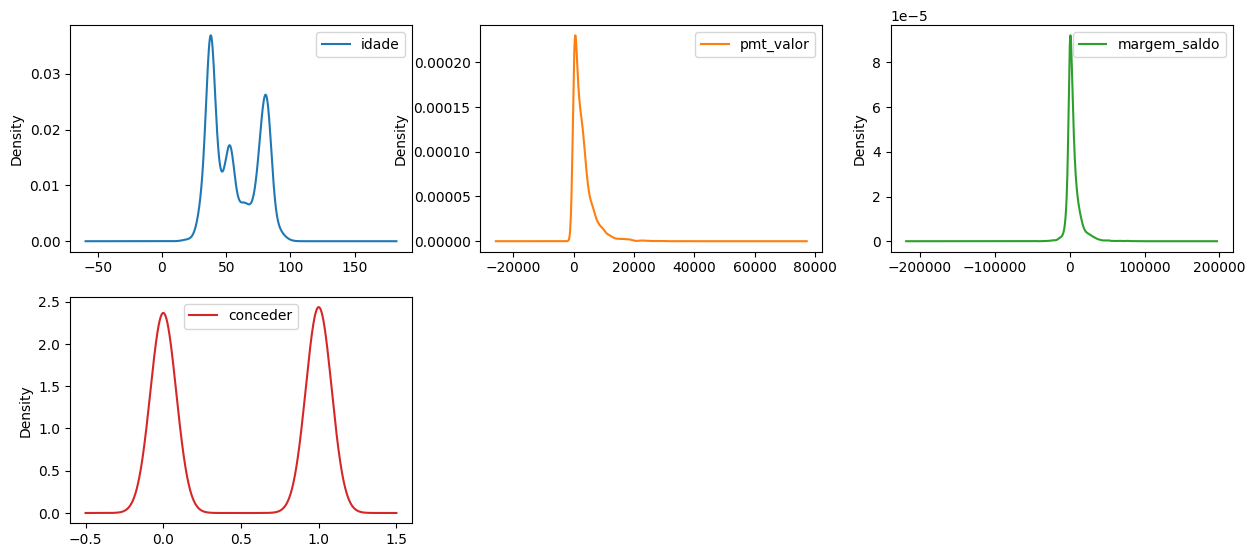

In [10]:
# Histograma
data_consig.plot(kind='density', subplots=True, layout=(3,3), sharex=False, figsize=(15,10))
plt.show

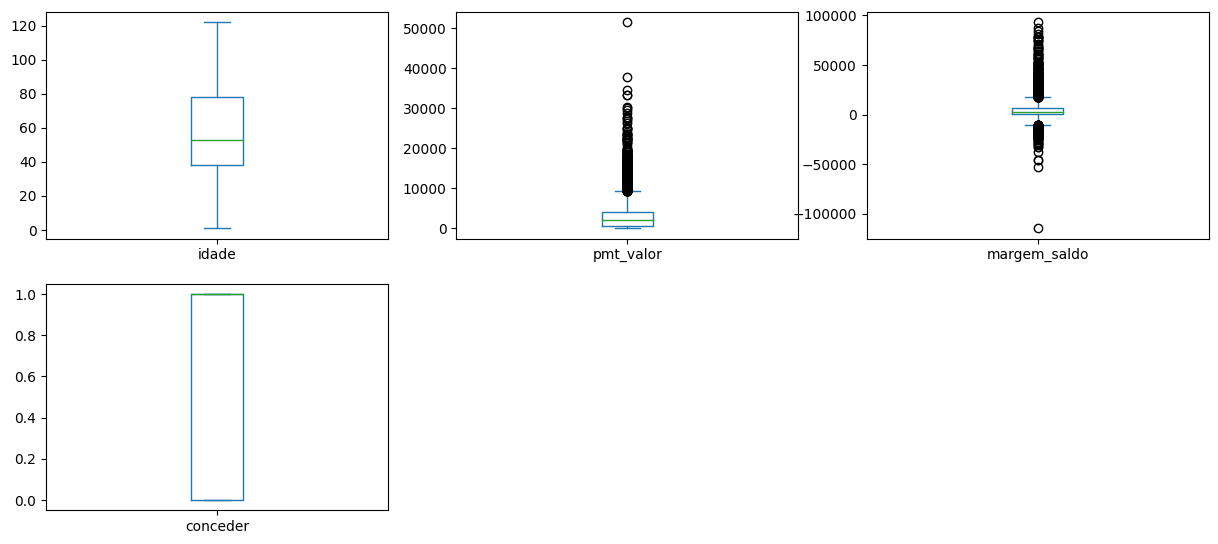

In [11]:
# Boxplot
data_consig.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (15,10))
plt.show()

* Percebemos claramente que os únicos atríbutos, pmt_valor e margem_saldo, possuem grande dispersão, o que faz total sentido em se tratando de valores.

# 4. Pré-processamento de dados

# 4.1. Análise de nulidade

In [12]:
data_consig.isnull().sum()

,0
sexo,0
idade,83
uf,100
situacao_funcional,0
pmt_valor,0
margem_saldo,0
conceder,0


<Axes: >

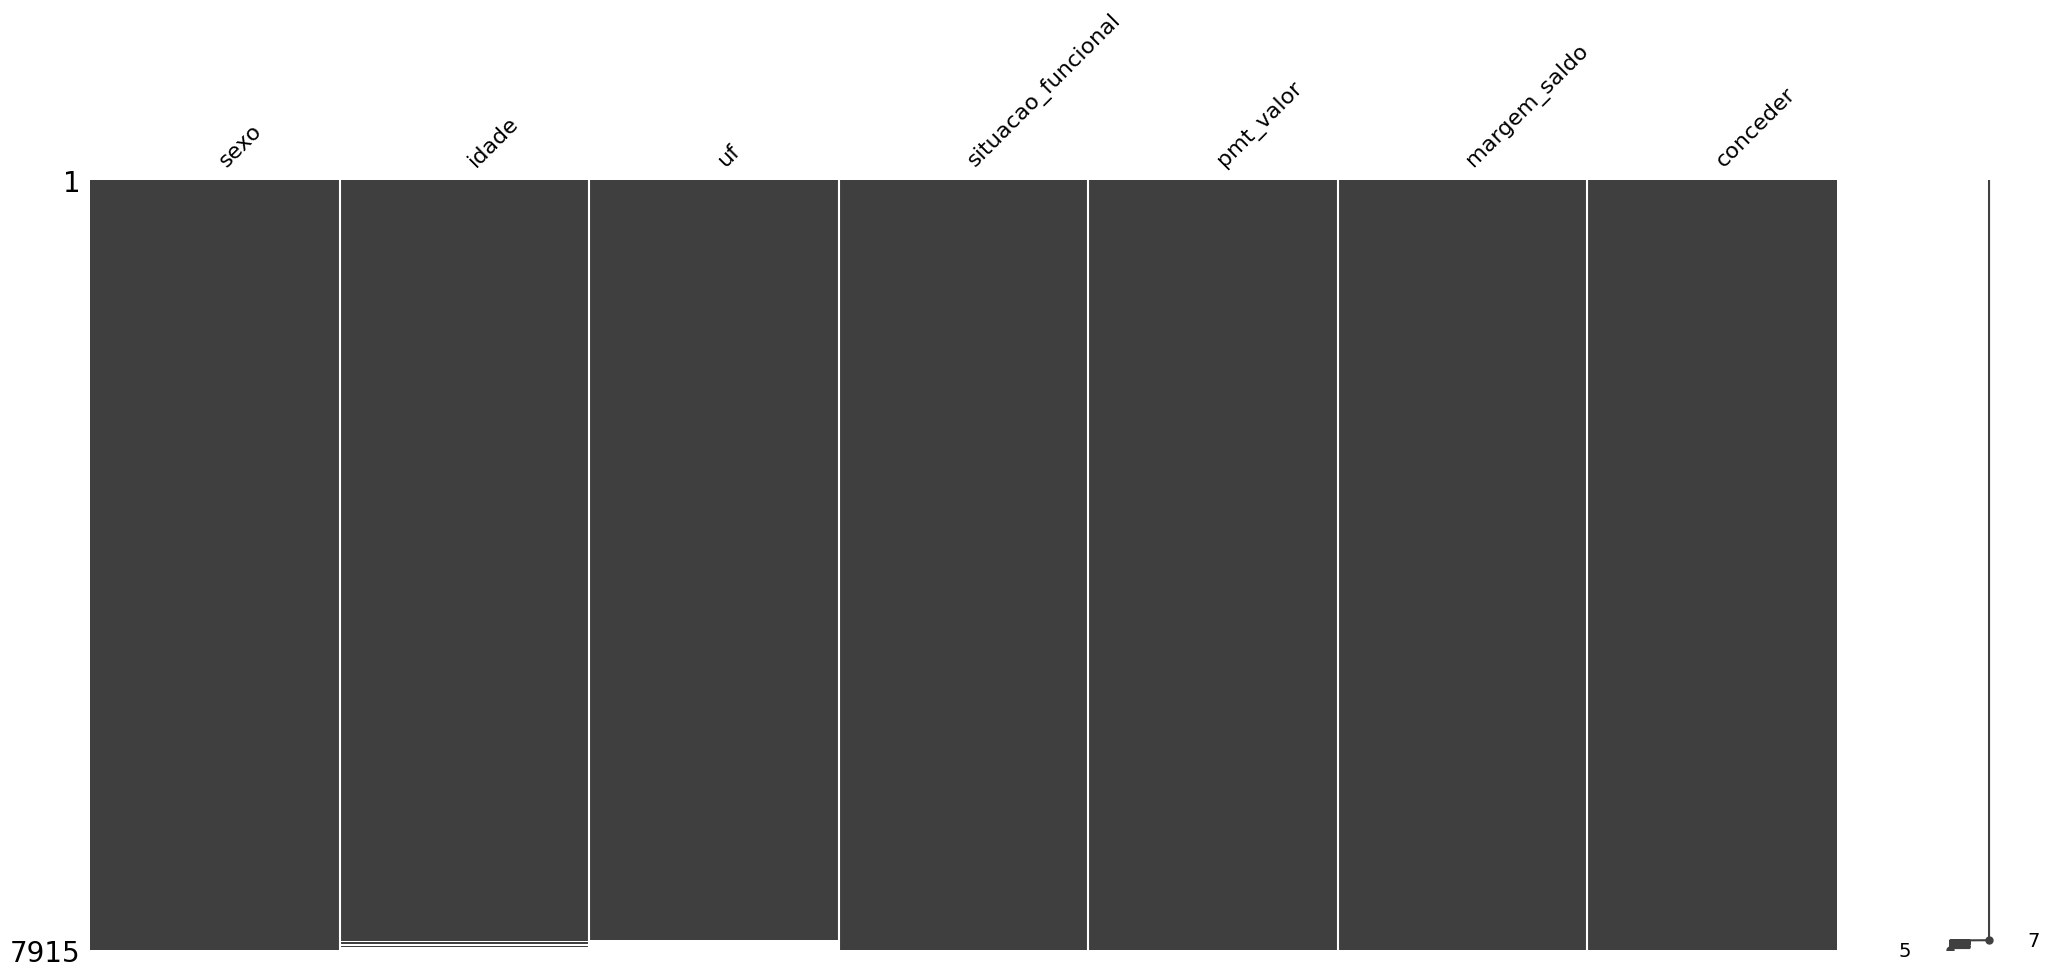

In [13]:
# salvando um novo dataset para tratamento de missings

# recuperando os nomes das colunas
col = list(data_consig.columns)

# o novo dataset irá conter todas as colunas do dataset original
datasetSemMissings = data_consig[col[:]]

# substituindo os zeros por NaN
#datasetSemMissings.replace(0, np.nan, inplace=True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(datasetSemMissings)

* Conforme observado, encontramos 100 registros de UF com valores nulos e 83 de idade. Precisaremos tratá-los.

# 4.2. Tratamento dos valores nulos

In [14]:
# Trataremos os valores nulos da idade, substituindo-os pela média ( vide ítem 3.1, onde a média = 56,61).

media_idade = data_consig['idade'].mean()
data_consig.loc[data_consig['idade'].isnull(), 'idade'] = media_idade


data_consig.isnull().sum()

,0
sexo,0
idade,0
uf,100
situacao_funcional,0
pmt_valor,0
margem_saldo,0
conceder,0


In [15]:
# Trataremos os valores nulos da UF removendo-os.
data_consig = data_consig.dropna(subset=['uf'])

data_consig.isnull().sum()



,0
sexo,0
idade,0
uf,0
situacao_funcional,0
pmt_valor,0
margem_saldo,0
conceder,0


In [16]:
# Convertendo a coluna idade em INT
data_consig['idade']=data_consig['idade'].astype(int)

# 4.4. Análise de balanceamento por Oversampling

In [17]:

# Funcão para contar os valores únicos da coluna "conceder" e verificar o balanceamento
np.unique(data_consig['conceder'], return_counts=True)

(array([0, 1]), array([3901, 3914]))

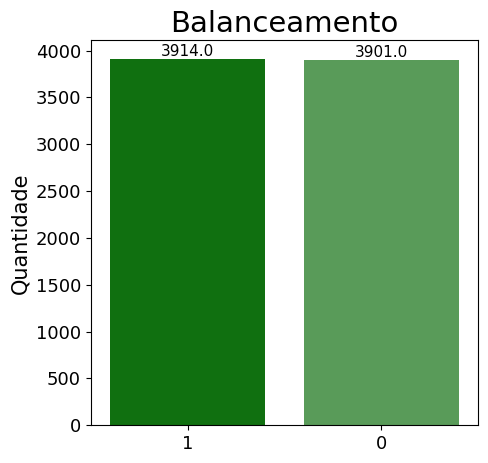

In [18]:
# Prepara a figura (fig) e a área do gráfico (ax)
palette_platform = sns.light_palette("green",4,reverse=True)
fig, ax = plt.subplots(figsize=(5,5))

# Cria o gráfico de contagem
sns.countplot(x='conceder', order=data_consig['conceder'].value_counts().index,
              data=data_consig, palette=palette_platform, ax=ax)

# Adiciona rótulos às barras com ajuste de posição
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height + 0.2),  # Ajustar o valor 0.2 conforme necessário
                ha='center',
                va='bottom',
                fontsize=11)

# Personalizações do gráfico
plt.xlim(-0.5,1.5)
plt.xlabel('')
plt.ylabel('Quantidade', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Balanceamento',fontsize=21)

# Exibe o gráfico
plt.show()


* Como podemos perceber no gráfico acima, o dataset está bem balanceado.

In [19]:
# Dividir entre previsores e classes
X = data_consig.drop('conceder', axis=1)
y = data_consig[['conceder']]

# Codificar variáveis categóricas
label_encoder_sexo = LabelEncoder()
label_encoder_uf = LabelEncoder()
label_encoder_sit_func = LabelEncoder()
#label_encoder_tp_cont = LabelEncoder()

X.iloc[:,0] = label_encoder_sexo.fit_transform(X.iloc[:,0])
X.iloc[:,2] = label_encoder_uf.fit_transform(X.iloc[:,2])
X.iloc[:,3] = label_encoder_sit_func.fit_transform(X.iloc[:,3])
#X.iloc[:,4] = label_encoder_tp_cont.fit_transform(X.iloc[:,4])

# Holdout
X_consig_training, X_consig_test, y_consig_training, y_consig_test = train_test_split(X, y)

In [20]:
# Funcão para validação cruzada
def cross_validation(model, X_consig, y_consig, oversampling=False):
    kfold = KFold(n_splits=10)

    # lista de acurácias de cada split
    accuracy_split = []

    for idx,(idx_training, idx_validation) in enumerate(kfold.split(X_consig)):
        X_split_training = X_consig.iloc[idx_training,:]
        y_split_training = y_consig.iloc[idx_training,:]

        # oversampling, só no split de treino!
        if oversampling:
            sm = SMOTE(random_state=42)
            X_split_training, y_split_training = sm.fit_resample(X_split_training, y_split_training)

        # Treinando o modelo
        model.fit(X_split_training, y_split_training.values.flatten())

        X_split_validation = X_consig.iloc[idx_validation, :]
        y_split_validation = y_consig.iloc[idx_validation, :]

        # Validação SEM oversampling
        predict_validation = model.predict(X_split_validation)

        acuracia_split = accuracy_score(y_split_validation, predict_validation)

        accuracy_split.append(acuracia_split)

        print(f'Acurácia do split {idx}: {accuracy_split}')
    return accuracy_split

In [21]:
# Criando o modelo
model_hgb = HistGradientBoostingClassifier()

# eliminando linhas que tenham algum valor missing, apenas neste dataset isolado
X_consig_training = X_consig_training.dropna(how='any')
y_consig_training = y_consig_training.dropna(how='any')



mean_accuracy_with_smote = mean(cross_validation(model_hgb, X_consig_training, y_consig_training, oversampling=False))
mean_accuracy_no_smote = mean(cross_validation(model_hgb, X_consig_training, y_consig_training, oversampling=True))

f'No smote: {mean_accuracy_no_smote:.02f}, with_smo: {mean_accuracy_with_smote:.02f}'

Acurácia do split 0: [0.9931856899488927]
Acurácia do split 1: [0.9931856899488927, 0.9948805460750854]
Acurácia do split 2: [0.9931856899488927, 0.9948805460750854, 0.9897610921501706]
Acurácia do split 3: [0.9931856899488927, 0.9948805460750854, 0.9897610921501706, 0.9829351535836177]
Acurácia do split 4: [0.9931856899488927, 0.9948805460750854, 0.9897610921501706, 0.9829351535836177, 0.9880546075085325]
Acurácia do split 5: [0.9931856899488927, 0.9948805460750854, 0.9897610921501706, 0.9829351535836177, 0.9880546075085325, 0.9948805460750854]
Acurácia do split 6: [0.9931856899488927, 0.9948805460750854, 0.9897610921501706, 0.9829351535836177, 0.9880546075085325, 0.9948805460750854, 0.9897610921501706]
Acurácia do split 7: [0.9931856899488927, 0.9948805460750854, 0.9897610921501706, 0.9829351535836177, 0.9880546075085325, 0.9948805460750854, 0.9897610921501706, 0.9948805460750854]
Acurácia do split 8: [0.9931856899488927, 0.9948805460750854, 0.9897610921501706, 0.9829351535836177, 0.

'No smote: 0.99, with_smo: 0.99'



    Com Oversampling = 0,99
    Sem Oversampling = 0,99

Como podemos notar, não houve ganho aplicando Oversampling. Desta forma, não iremos utilizá-lo.

** Importante: realizamos essas análise, apenas em uma base de treinamento isolada.


# 3.5 Análise da UF

**Realizaremos a partir de agora todas as análises em cima dos registros que poderemos conceder o crédito.**

In [22]:
# Filtrando o dataset para os casos passíveis de concessão, onde a classe de saída é igual à 0.
df_filter = data_consig.query("conceder == 0")
df_filter

,sexo,idade,uf,situacao_funcional,pmt_valor,margem_saldo,conceder
0,MASCULINO,80,PA,APOSENTADO,411.60,2246.28,0
1,FEMININO,59,RJ,ATIVO PERMANENTE,1229.02,15264.76,0
2,FEMININO,38,MS,ATIVO PERMANENTE,1250.04,3126.68,0
3,FEMININO,80,PE,APOSENTADO,721.14,20262.96,0
4,MASCULINO,37,RS,ATIVO PERMANENTE,90.14,2867.68,0
...,...,...,...,...,...,...,...
3896,FEMININO,79,PE,APOSENTADO,29.85,1109.22,0
3897,MASCULINO,35,DF,ATIVO PERMANENTE,2372.26,18545.71,0
3898,FEMININO,68,RJ,APOSENTADO,3738.93,7379.43,0
3899,FEMININO,45,MG,ATIVO PERMANENTE,2405.02,3507.87,0


In [23]:
df_filter.describe()

,idade,pmt_valor,margem_saldo,conceder
count,3901.000000,3901.000000,3901.000000,3901.0
mean,59.522174,1675.220479,9850.530385,0.0
std,19.525180,2181.228021,10102.311273,0.0
min,1.000000,6.550000,242.840000,0.0
25%,39.000000,248.660000,3540.030000,0.0
50%,56.000000,808.690000,6642.840000,0.0
75%,80.000000,2245.160000,12503.720000,0.0
max,84.000000,27866.290000,93011.760000,0.0


* Percebemos que após filtrarmos os casos, a média de idade subiu para 59 anos, bem como a margem saldo que subiu para 9.000.

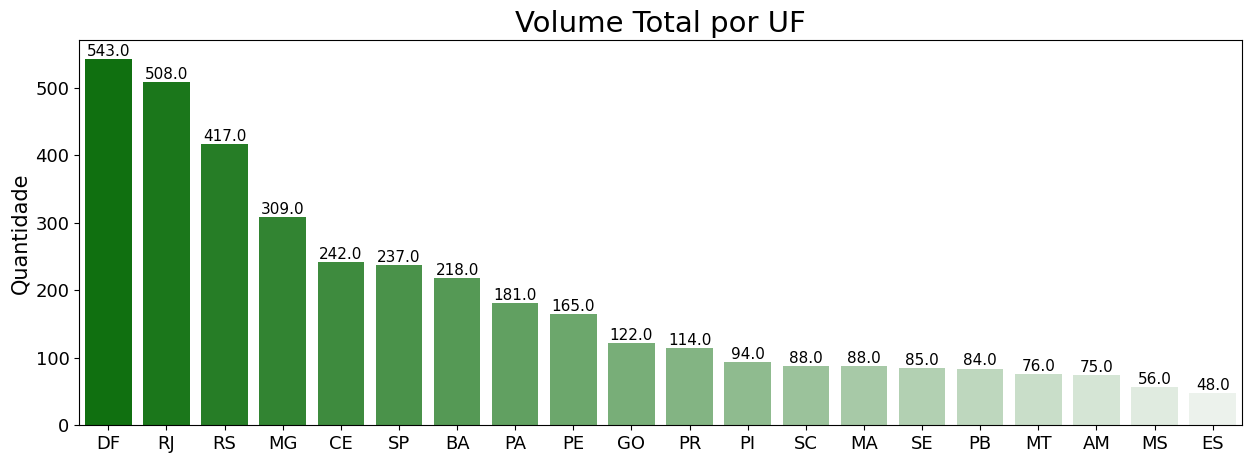

In [24]:
# Prepara a figura (fig) e a área do gráfico (ax)
palette_platform = sns.light_palette("green",20,reverse=True)
fig, ax = plt.subplots(figsize=(15,5))

# Cria o gráfico de contagem
sns.countplot(x='uf', order=df_filter['uf'].value_counts().index,
              data=df_filter, palette=palette_platform, ax=ax)

# Adiciona rótulos às barras com ajuste de posição
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height + 0.2),  # Ajustar o valor 0.2 conforme necessário
                ha='center',
                va='bottom',
                fontsize=11)

# Personalizações do gráfico
plt.xlim(-0.5,19.5)
plt.xlabel('')
plt.ylabel('Quantidade', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Volume Total por UF',fontsize=21)

# Exibe o gráfico
plt.show()

In [25]:
""" df_fe = data_consig
df_fe = df_fe.filter(items=['idade', 'uf'])
df_fe.head()
 """

" df_fe = data_consig\ndf_fe = df_fe.filter(items=['idade', 'uf'])\ndf_fe.head()\n "

In [26]:
df_agrupado = df_filter.groupby(['uf'])['idade'].mean().reset_index()
df_agrupado['idade'] = df_agrupado['idade'].astype(int)
df_agrupado.head()

,uf,idade
0,AC,51
1,AL,58
2,AM,66
3,AP,54
4,BA,64


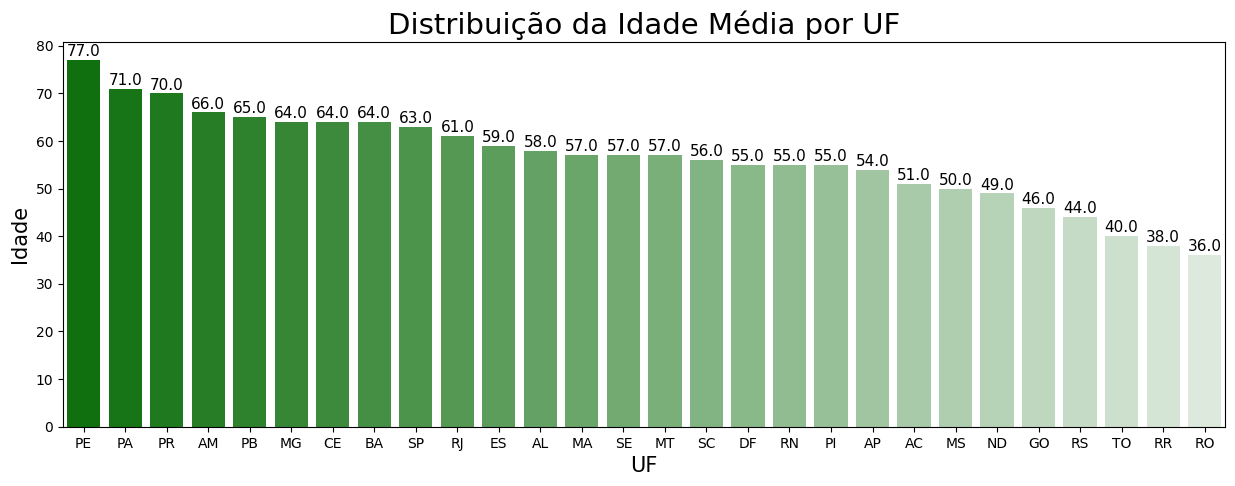

In [27]:
df_agrupado = df_agrupado.sort_values('idade', ascending=False)

# Prepara a figura (fig) e a área do gráfico (ax)
palette_platform = sns.light_palette("green",30,reverse=True)
fig, ax = plt.subplots(figsize=(15,5))

# Criando um boxplot
sns.barplot(x='uf', y='idade', data=df_agrupado, palette=palette_platform, ax=ax)
# Adiciona rótulos às barras com ajuste de posição
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height + 0.2),  # Ajustar o valor 0.2 conforme necessário
                ha='center',
                va='bottom',
                fontsize=11)


# Personalizações (ajuste de acordo com suas necessidades)
plt.xlabel('UF', fontsize=15)
plt.ylabel('Idade', fontsize=15)
plt.title('Distribuição da Idade Média por UF', fontsize=21)

plt.show()

In [28]:
# Filtrando o dataset para conter somente os campos UF e Margem_Saldo
df_ms = data_consig.query("conceder == 0")
df_ms = df_ms.filter(items=['uf','margem_saldo'])
df_ms.head()

,uf,margem_saldo
0,PA,2246.28
1,RJ,15264.76
2,MS,3126.68
3,PE,20262.96
4,RS,2867.68


In [29]:
# Agrupando a UF pela margem de saldo média
df_aggr_ms = df_ms.groupby(['uf'])['margem_saldo'].mean().reset_index()
df_aggr_ms['margem_saldo'] = df_aggr_ms['margem_saldo'].apply(lambda x:round(x,2))
df_aggr_ms.head()

,uf,margem_saldo
0,AC,7989.73
1,AL,7715.36
2,AM,12321.90
3,AP,9668.64
4,BA,9460.23


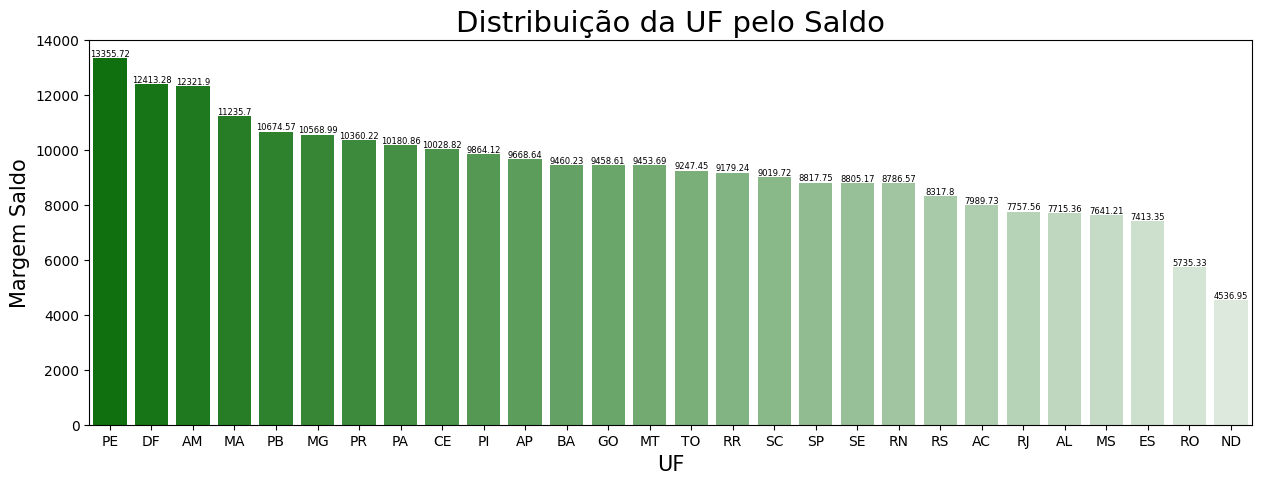

In [30]:
df_aggr_ms = df_aggr_ms.sort_values('margem_saldo', ascending=False)

# Prepara a figura (fig) e a área do gráfico (ax)
palette_platform = sns.light_palette("green",30,reverse=True)
fig, ax = plt.subplots(figsize=(15,5))

# Criando um boxplot
sns.barplot(x='uf', y='margem_saldo', data=df_aggr_ms, palette=palette_platform, ax=ax)
# Adiciona rótulos às barras com ajuste de posição
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height + 0.2),  # Ajustar o valor 0.2 conforme necessário
                ha='center',
                va='bottom',
                fontsize=6)


# Personalizações (ajuste de acordo com suas necessidades)
plt.xlabel('UF', fontsize=15)
plt.ylabel('Margem Saldo', fontsize=15)
plt.title('Distribuição da UF pelo Saldo', fontsize=21)

plt.show()

# 5. Conclusão

- Volume por UF: Analisando a mediana do volume total por UF, já com o filtro, temos um valor de 250 aproximadamente. Desta forma as UFs relevantes são: DF,RJ,RS,MG e CE
- Idade: Como a média aumento para 59 anos, temos como principais UFs: PE,PA,PR,AM,PB,MG,CE,BA,SP,RJ e ES.
- UF/Saldo: Como a mediana ficou em cerca de 9.000 e temos muitas UFs, começaremos a focar nas 10 primeiras, que são: PE,DF,AM,MA,PB,MG,PR,PA,CE e PI.

Dito isso, percebemos interseção para as UFs: RJ, MG e CE. Desta forma, realizaremos ações para os clientes destes estados a fim de aumentarmos as vendas.